# 1. Setup

In [8]:
#!unzip bees_data.zip

## 1.1 Imports

In [8]:
%pip install seaborn imageio scikit-image

  Using cached scikit_image-0.21.0-cp311-cp311-win_amd64.whl (22.8 MB)
  Using cached tifffile-2023.8.30-py3-none-any.whl (221 kB)
  Using cached PyWavelets-1.4.1-cp311-cp311-win_amd64.whl (4.2 MB)
  Using cached lazy_loader-0.3-py3-none-any.whl (9.1 kB)
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout
import tensorflow as tf

import utils

## 1.2 Set random seeds

In [10]:
np.random.seed(117)
tf.random.set_seed(117)

## 1.3 Global variables

In [11]:
img_width = 100
img_height = 100
img_channels = 3

# 2. Carga de datos

In [12]:
bees, bees_test_for_evaluation = utils.read_data()

In [13]:
bees.head()

,id,datetime,file,location,zip code,subspecies,health,pollen_carrying,caste
0,0,2018-08-06 14:48:00,020_011.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker
1,1,2018-08-21 09:00:00,032_507.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
2,2,2018-08-21 09:00:00,032_612.png,"Des Moines, IA, USA",50315,Russian honey bee,healthy,False,worker
3,3,2018-08-17 17:50:00,030_773.png,"Alvin, TX, USA",77511,Italian honey bee,ant problems,False,worker
4,4,2018-08-06 13:19:00,015_1052.png,"Saratoga, CA, USA",95070,Italian honey bee,healthy,False,worker


In [14]:
bees_test_for_evaluation.head()

,id,datetime,file,location,zip code,pollen_carrying,caste
0,0,2018-08-28 16:07:00,042_012.png,"Alvin, TX, USA",77511,False,worker
1,1,2018-08-10 13:54:00,022_114.png,"Saratoga, CA, USA",95070,False,worker
2,2,2018-08-18 12:30:00,038_384.png,"Athens, Georgia, USA",30607,False,worker
3,3,2018-08-17 17:50:00,030_740.png,"Alvin, TX, USA",77511,False,worker
4,4,2018-07-07 12:56:00,005_310.png,"Saratoga, CA, USA",95070,False,worker


# 3. Análisis exploratorio de datos

## 3.1 Análisis descriptivo: Distribuciones, Scatterplots, Barplots...

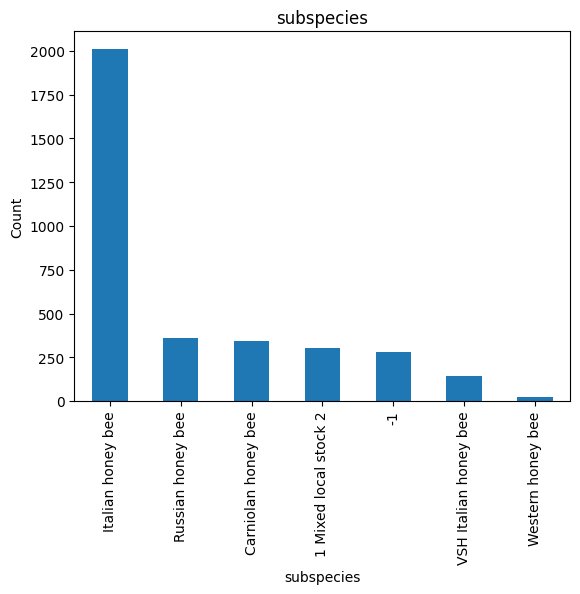

In [15]:
utils.value_counts(bees, 'subspecies')

## 3.2 Ver imágenes

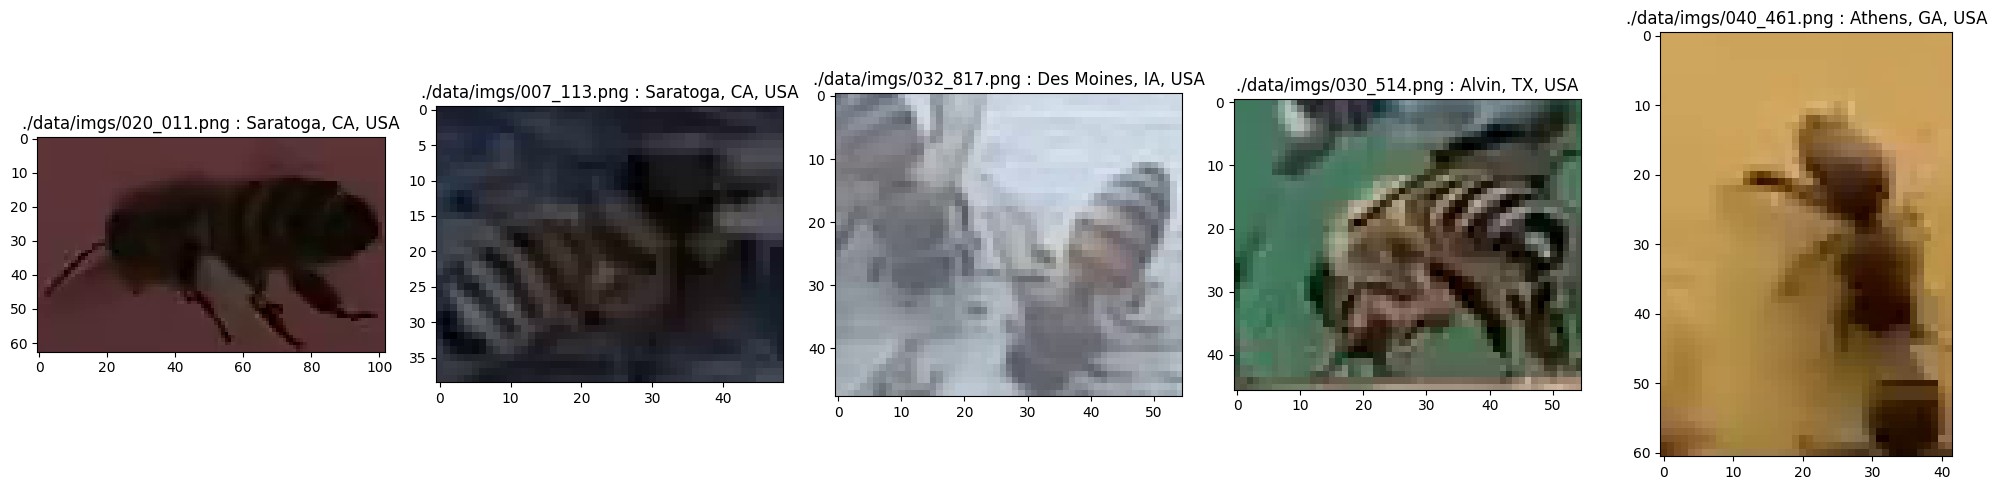

In [16]:
utils.plot_images(bees, 'location', [0, 18, 24, 38, 45])

# 4. Clasificación

## 4.1. Data preprocessing
### 4.1.1 Particionamiento

In [17]:
train_bees, val_bees, test_bees = utils.split(bees)


### 4.1.2 Carga de imágenes

In [18]:
train_X, val_X, test_X, train_y, val_y, test_y = utils.load_images_and_target(train_bees, 
                                                                              val_bees, 
                                                                              test_bees,
                                                                              'subspecies',
                                                                              img_width, 
                                                                              img_height,
                                                                              img_channels)

## 4.2 CNN

In [19]:
optimizer = 'sgd'
loss = 'categorical_crossentropy'

In [20]:
model1 = Sequential()
model1.add(Flatten(input_shape =(img_height, img_width, img_channels)))
model1.add(Dense(train_y.columns.size, activation = 'softmax'))
model1.compile(optimizer = optimizer, loss = loss, metrics = ['accuracy'])

## 4.3 Entrenamiento

### 4.2.2 Parámetros de transformación de imágenes (data augmentation)

In [21]:
rotation_range = 15      # rotación aleatoria en grados entre 0 a rotation_range
zoom_range = 0.1         # zoom aleatorio
width_shift_range = 0.1  # desplazamiento horizontal aleatorio (fracción del total)
height_shift_range = 0.1 # desplazamiento vertical aleatorio (fracción del total)
horizontal_flip = True   # transposición horizontal
vertical_flip = True     # transposición horizontal

In [22]:
batch_size = 10
epochs = 5
steps_per_epoch = 10
patience = 10
class_weights = utils.class_weights(bees, 'subspecies')

In [23]:
class_weights

{0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1}

In [24]:
training1, model1 = utils.train(model1,
                train_X,
                train_y, 
                batch_size = batch_size,
                epochs = epochs,
                validation_data_X = val_X, 
                validation_data_y = val_y,
                steps_per_epoch = steps_per_epoch,
                rotation_range = rotation_range,
                zoom_range = zoom_range, 
                width_shift_range = width_shift_range,
                height_shift_range = height_shift_range,
                horizontal_flip = horizontal_flip,  
                vertical_flip = vertical_flip,
                patience = patience,
                class_weights = class_weights
                               )

Epoch 1/5
10/10 [==============================] - 2s 96ms/step - loss: 19.2368 - accuracy: 0.3469 - val_loss: 21.2130 - val_accuracy: 0.4000
Epoch 2/5
10/10 [==============================] - 1s 55ms/step - loss: 24.0376 - accuracy: 0.4200 - val_loss: 23.6517 - val_accuracy: 0.0192
Epoch 3/5
10/10 [==============================] - 1s 51ms/step - loss: 19.6742 - accuracy: 0.4100 - val_loss: 9.2850 - val_accuracy: 0.6423
Epoch 4/5
10/10 [==============================] - 0s 41ms/step - loss: 20.6862 - accuracy: 0.3400 - val_loss: 14.6249 - val_accuracy: 0.1308
Epoch 5/5
10/10 [==============================] - 0s 40ms/step - loss: 15.5051 - accuracy: 0.4200 - val_loss: 30.1646 - val_accuracy: 0.1308


## 4.3 Evaluación del modelo

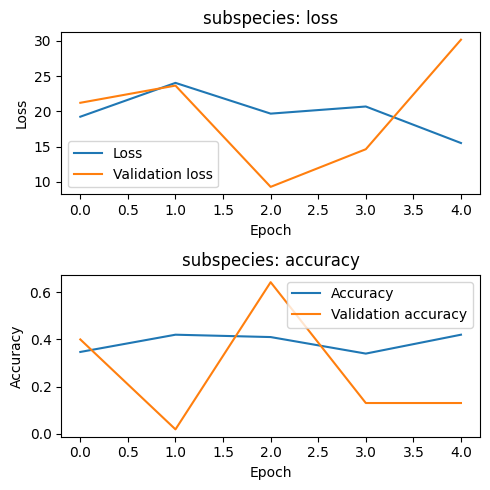

28/28 [==============================] - 0s 4ms/step


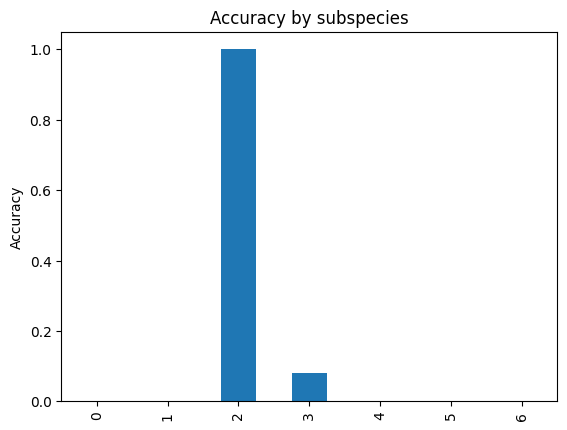

Classification report
                       precision    recall  f1-score   support

                   -1       0.00      0.00      0.00        70
1 Mixed local stock 2       0.00      0.00      0.00        69
  Carniolan honey bee       0.11      1.00      0.20        92
    Italian honey bee       0.83      0.08      0.15       490
    Russian honey bee       0.00      0.00      0.00       110
VSH Italian honey bee       0.00      0.00      0.00        29
    Western honey bee       0.00      0.00      0.00         7

             accuracy                           0.15       867
            macro avg       0.14      0.15      0.05       867
         weighted avg       0.48      0.15      0.11       867

Loss function: 30.456493377685547, accuracy: 0.15224912762641907


In [25]:
utils.eval_model(training1, model1, test_X, test_y, 'subspecies')

## 4.4 Evaluación y generación de archivo para competencia Kaggle

In [26]:
df_subspecies = utils.load_test_and_generate_prediction_file(model1, img_width, img_height, img_channels)

In [27]:
df_subspecies

,id,expected
0,0,1 Mixed local stock 2
1,1,Italian honey bee
2,2,Carniolan honey bee
3,3,Italian honey bee
4,4,Carniolan honey bee
...,...,...
1702,1702,Italian honey bee
1703,1703,1 Mixed local stock 2
1704,1704,Carniolan honey bee
1705,1705,Carniolan honey bee
